In [5]:
# import general packages:
import numpy as np
import pandas as pd
from pandas import Grouper
from pandas import Timestamp
import os
import datetime as dt
import time 
from scipy.stats import boxcox
# import feather
import itertools
from math import sqrt
import csv
import datetime
# import timestring
from IPython.core.display import display, HTML

# import visualization packages:
from matplotlib import pyplot as plt
import seaborn as sns
# import ggplot

# import modeling pacakges:
import statsmodels.api as sm
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn import metrics
from sklearn.kernel_ridge import KernelRidge

In [6]:
# make jynb full screen 
display(HTML("<style>.container { width:100% !important; }</style>"))

In [7]:
# pd.set_option('display.max_columns', None)
# pd.set_option('display.max_rows', 1000)
# pd.set_option('display.max_colwidth', 1000)

In [8]:
# os.chdir('S:\\CORP-Share\\DEPT\\IT\\STRATEGY\\Advanced Analytics\\Nathan\\1.GPSC_Project\Pricing_Index\\Data')
os.chdir('C:\\Users\\u279014\\Documents\\H_Drive\\7.AA Models\\2.Claw_back_Analysis\\Data')
os.makedirs('temp',exist_ok=True)

In [9]:
file = [f for f in os.listdir() if'JLG' in f][0]
df_index = pd.read_excel(file,sheet_name='Sheet1',skiprows=[0])

file = [f for f in os.listdir() if'PPV filtered for steel impact' in f][0]
df_pp = pd.read_csv(file)

file = [f for f in os.listdir() if'DirectedBuyFabricatorPricing' in f][0]
df_db = pd.read_csv(file)

file = [f for f in os.listdir() if'Dir_Buy_Index' in f][0]
df_index_list = pd.read_csv(file,skiprows=[0])

file = [f for f in os.listdir() if'Volume' in f][0]
df_vol = pd.read_csv(file)

## 1.Direct_buy PPV analysis

### Direct-buy index data set

In [10]:
# trim full index data set to CRU only
df_index = df_index.loc[:,['Period', 'Year', ' Quarter', 'Cal Mo ID', 'Month', 'CRU HRC','CRU Plate', 'Platts Plate']]

# build feather format for faster reading and writing
df_index.to_feather('temp/fname_ind')
#df_ppvto_feather('temp/fname_ppv')

# read feather file
df_index_f = feather.read_dataframe ('temp/fname_ind')
#df_ppv_f = feather.read_dataframe ('temp/fname_ppv')

NameError: name 'feather' is not defined

In [ ]:
df_index_f = df_index_f[np.logical_and(df_index_f['Month']>'2018-06-01',df_index_f['Month']<'2019-08-01')]
df_index_f = df_index_f[df_index_f['Year'] != 'FY18']
df_index_f.drop_duplicates(subset=['Period'],keep='first',inplace=True)

### PPV data set prep.

In [ ]:
# trim full index data 
df_pp = df_pp.loc[:,['MONTH','SUPPLIER #','SUPPLIER NAME','ITEM #','ITEM DESCRIPTION',' STD MAT ', ' CUR MAT ', ' PPV ']]

# build feather format for faster reading and writing
df_pp.to_feather('temp/fname_pp')
#df_ppv.to_feather('temp/fname_ppv')

# read feather file
df_pp_f = feather.read_dataframe ('temp/fname_pp')
#df_ppv_f = feather.read_dataframe ('temp/fname_ppv')

In [ ]:
# df_pp_f['MAT_Diff'] = df_pp_f['CUR MAT']-df_pp_f['STD MAT']
# df_pp_f['MAT_Diff_%'] = df_pp_f['MAT_Diff']/df_pp_f['STD MAT']*100
df_pp_f['MON_ID'] = 'Q' + df_pp_f.MONTH.apply(lambda x: int(int(x.split('-')[0])/4)+1).astype(str)
df_pp_f.drop_duplicates(subset=['MONTH','SUPPLIER #','ITEM #'],keep='last',inplace=True)

In [ ]:
# Supplier name duplication clean
df_pp_f['SUPPLIER NAME'] = df_pp_f['SUPPLIER NAME'].apply(lambda x: x.replace('AAA SALES & ENGINEERING,','AAA SALES AND ENGINEERING'))
df_pp_f['SUPPLIER #'] = df_pp_f['SUPPLIER #'].fillna(0).astype(int)
df_pp_f['SUPPLIER #'] = df_pp_f['SUPPLIER #'].astype(int)
df_pp_f['SUPPLIER #'] = df_pp_f['SUPPLIER #'].astype(str)

### Direct buy parts prep.

In [ ]:
# trim full index data set to CRU only
df_db_f = df_db.loc[:,['PARENT PART NUMBER LEVEL 1','Parts Type','Fabricator Number','Fabricator',' Quarter_Price ', ' Period ']]

In [ ]:
# clean direct_buy duplication
df_db_f.drop_duplicates(subset=['PARENT PART NUMBER LEVEL 1',' Period '],keep='first',inplace=True)

# clean white space
df_db_f[' Period '] = df_db_f[' Period '].apply(lambda x: x.strip())

### Volume prep.

In [ ]:
# trim full data set
df_vol = df_vol.loc[:,['PI Supplier - Supplier Id', 'PI Supplier - Supplier Name','PI Activ Measures - Item Id', 
                       'PI Invoice Date - Calendar Yr and Mth Number','PI Activ Measures - Invoice Qty','FYQ']]

# build feather format for faster reading and writing
df_vol.to_feather('temp/fname_vol')
#df_ppvto_feather('temp/fname_ppv')

# read feather file
df_vol_f = feather.read_dataframe ('temp/fname_vol')
df_vol_f['PI Activ Measures - Item Id'] = df_vol_f['PI Activ Measures - Item Id'].astype(str)
df_vol_f['PI Supplier - Supplier Id'] = df_vol_f['PI Supplier - Supplier Id'].astype(str)
df_vol_f['PI Activ Measures - Invoice Qty'] = df_vol_f['PI Activ Measures - Invoice Qty'].apply(lambda x: x.replace(',','')).astype(int)

# aggregate material by invoiced qty sum() same: supplier_id + item_id + year and month
df_vol_f = df_vol_f.groupby(['PI Supplier - Supplier Id',
                  'PI Activ Measures - Item Id',
                  'PI Invoice Date - Calendar Yr and Mth Number',
                  'FYQ'])['PI Activ Measures - Invoice Qty'].sum().reset_index()

# time split for month
df_vol_f['month'] = df_vol_f['PI Invoice Date - Calendar Yr and Mth Number'].apply(lambda x: int(str(x)[-2:]))

### Tables merging process

In [ ]:
# PPV & Index merging
df_pp_index = df_pp_f.merge(df_index_f[[' Quarter','Period','CRU HRC','CRU Plate','Platts Plate']],left_on='MON_ID', right_on=' Quarter',how='left')

# ppv & direct_buy mergeing
df_pp_index_db = df_pp_index.merge(df_db_f[[' Quarter_Price ','PARENT PART NUMBER LEVEL 1','Parts Type',' Period ',]],left_on=['ITEM #','MON_ID'], right_on=['PARENT PART NUMBER LEVEL 1',' Period '], how='inner')

In [ ]:
# ppv & Index_list_break_down merging
df_pp_idx_db_ls = df_pp_index_db.merge(df_index_list[['PARENT PART NUMBER','PRIMARY INDEX']],left_on='ITEM #', right_on='PARENT PART NUMBER',how='left')
df_pp_idx_db_ls['month'] = df_pp_idx_db_ls.MONTH.apply(lambda x: timestring.Date(x).month)

In [ ]:
df_pp_idx_db_ls.sort_values(by=['ITEM #','MONTH'],ascending=True,inplace=True)

In [ ]:
# ppv & vol merging
df_pp_idx_db_ls_vol = df_pp_idx_db_ls.merge(df_vol_f[['PI Supplier - Supplier Id','PI Activ Measures - Item Id','PI Activ Measures - Invoice Qty','month','FYQ']],
                                            left_on=['SUPPLIER #','ITEM #','month'],
                                            right_on=['PI Supplier - Supplier Id','PI Activ Measures - Item Id','month'], 
                                            how='left')

In [ ]:
# direct_buy calculated PPV
df_pp_idx_db_ls_vol ['NET_PPV'] = (df_pp_idx_db_ls_vol[' Quarter_Price ']\
                                   -df_pp_idx_db_ls_vol[' CUR MAT '])\
                                   *df_pp_idx_db_ls_vol['PI Activ Measures - Invoice Qty']

df_final_direct = df_pp_idx_db_ls_vol.drop(columns=[ 'MON_ID', ' Quarter','PARENT PART NUMBER LEVEL 1', ' Period ',
                                  'PARENT PART NUMBER','PI Supplier - Supplier Id',
                                  'PI Activ Measures - Item Id','FYQ'])

### Summarize direct_buy parts PPV

In [ ]:
# report creation
df_final_direct_GP = df_final_direct.groupby(['SUPPLIER #','SUPPLIER NAME','ITEM #'])[['NET_PPV']].sum().reset_index()
df_final_direct_GP_negative_500 = df_final_direct[df_final_direct['NET_PPV']<-500]

In [ ]:
# csv creartion
df_final_direct.to_csv(r'result_direct_buy_items_ppv.csv',index=False,header=True)
df_final_direct_GP_negative_500.to_csv(r'result_direct_buy_negative_ppv_less_500.csv',index=False,header=True)

### Visulizations

####  - Supplier Opportunity

In [ ]:
def rank_plot(df,supplier = 'SUPPLIER NAME',ppv= ' PPV '):
    sns.set(style = 'whitegrid')
    f, ax = plt.subplots(figsize = (12,8))

    sns.barplot(x=ppv, y=supplier, data=df,palette = 'Blues_d', \
                hue_order = df[ppv],\
                order=df.iloc[:,0])

    ax.set(ylabel = '',xlabel = 'Parts Price Variance as opportunity')

In [ ]:
# opportunity by supplier
supplier_ppv_agg = df_pp_f[df_pp_f[' PPV ']>0].groupby('SUPPLIER NAME')[' PPV '].sum().reset_index()
supplier_qt_08 = df_pp_f[df_pp_f[' PPV ']>0].groupby('SUPPLIER NAME')[' PPV '].sum().quantile(0.8)
supplier_ppv_agg_plus08 = supplier_ppv_agg[supplier_ppv_agg[' PPV ']>supplier_qt_08].sort_values(by = ' PPV ',ascending = False)

In [ ]:
result_supplier_ppv_agg = df_final_direct_GP[df_final_direct_GP.NET_PPV <0].groupby('SUPPLIER NAME')['NET_PPV'].sum().reset_index()
result_supplier_ppv_agg.NET_PPV = result_supplier_ppv_agg.NET_PPV.abs()

In [ ]:
result_supplier_qt_08 = result_supplier_ppv_agg.groupby('SUPPLIER NAME')['NET_PPV'].sum().quantile(0.6)
result_supplier_ppv_agg_plus08 = result_supplier_ppv_agg[result_supplier_ppv_agg.NET_PPV > \
                                                         result_supplier_qt_08].sort_values(by = 'NET_PPV', ascending = True)
    
result_supplier_ppv_agg_plus08 = result_supplier_ppv_agg_plus08[['SUPPLIER NAME','NET_PPV']].sort_values(by = 'NET_PPV', ascending=False)

In [ ]:
result_supplier_ppv_agg_plus08

In [ ]:
# csv creartion
supplier_ppv_agg.to_csv(r'result_original_supplier_ppv.csv',index=False,header=True)

In [ ]:
# Original PPV: 
rank_plot(supplier_ppv_agg_plus08)

In [ ]:
# Opportuniy PPV for Clawback:
rank_plot(result_supplier_ppv_agg_plus08, ppv = 'NET_PPV')

In [ ]:
# PPV_pct
result_supplier_ppv_agg_plus08['PPV_pct']=result_supplier_ppv_agg_plus08.NET_PPV/result_supplier_ppv_agg_plus08.NET_PPV.sum()

# find top 10 worst PPV 
result_supplier_ppv_agg_plus08.head(10)

### - Material opportunity

In [ ]:
# quick find supplier code
def find_supplier_code(key_name):
    return df_final_direct_GP[df_final_direct_GP['SUPPLIER NAME'].apply(lambda x: key_name in x.lower())]['SUPPLIER #'].unique()

In [ ]:
# indexing supplier number
target = find_supplier_code('MILL')[0]

# opportunity by material
supplier_material_ppv_agg = (df_final_direct_GP[np.logical_and(df_final_direct_GP['SUPPLIER #'] == target,\
                                                         df_final_direct_GP.NET_PPV <0)]).groupby('ITEM #')['NET_PPV'].sum().reset_index()

In [ ]:
supplier_material_ppv_agg['PPV_pct']=supplier_material_ppv_agg.NET_PPV/supplier_material_ppv_agg.NET_PPV.sum()
supplier_material_ppv_agg.sort_values(by = 'NET_PPV',ascending=True,inplace=True)
supplier_material_ppv_agg.head(10)

## 2.Non_Direct-Buy PPV Analysis

In [19]:
def col_name(df):
    df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('(', '').str.replace(')', '')
    return df

In [20]:
def plot_info(df,title = 'purpose of plot'):
    # timeseries plot all
    df.plot()
    plt.axis()
    plt.gcf().set_size_inches(11,8)
    plt.title(title) 

In [21]:
# filter df only including materials sold in all s periods
def all_season_item(df,dup_list,s):
    """
    dup_list: unique by combination of items in the list
    s       : period lags to choose
    """
    y = df.drop_duplicates(subset=dup_list) # find unique on combination criteria
    x = y.groupby(dup_list[0])[dup_list[1]].count().reset_index() # group by count month appearance
    x = x[x[dup_list[1]] == s] # bool selection on desire month
    df = y[y[dup_list[0]].isin(x[dup_list[0]])] # datafram only has required month count
    return df.reset_index(drop = True)

In [22]:
def plot_index_info(*args,title = 'x-periods'):
    # timeseries plot all
    T_1 = args[0].index
    T_2 = args[1].index

    fig, ax1 = plt.subplots( figsize=(8,6))
    ax1.set_xlabel('year',fontsize = 10)
    ax1.set_ylabel('CRU_Index',fontsize = 10)
    lns1 = ax1.plot(T_1,args[0],'b', label = 'index')
    
    ax2 = ax1.twinx()
    ax2.set_ylabel('Billed Price',fontsize = 10)
    lns2 = ax2.plot(T_2,args[1],'g', label = 'price') 
    
    fig.legend(loc = 1, fontsize = 'large')    
    plt.title(f'Index vs Billed price in {title}', fontsize=15)  
    plt.savefig(f'{title}.pdf') 

In [23]:
file = [f for f in os.listdir() if'Directed Buy - Index Record' in f][0]
df_ndb_index = pd.read_excel(file,sheet_name='Sheet1',skiprows=[0])

file = [f for f in os.listdir() if'DirectedBuyFabricatorPricing' in f][0]
df_db = pd.read_csv(file)

file = [f for f in os.listdir() if 'Non_Dir_Buy' in f][0]
df_pp_ndb = pd.read_csv(file, encoding = "ISO-8859-1", low_memory = False)

In [24]:
# trim full index data set to CRU only
df_ndb_index = df_ndb_index.loc[:,['Period','Year',' Quarter','Cal Mo ID','Month','CRU HRC']]

# build feather format for faster reading and writing
df_ndb_index.to_feather('temp/fname_ndb_ind')
#df_ppvto_feather('temp/fname_ppv')

# read feather file
df_ndb_index_f = feather.read_dataframe ('temp/fname_ndb_ind')

# create a yyyy-mm col for join with parts data set
df_ndb_index_f['YYYYMM'] = df_ndb_index_f.Month.apply(lambda x: str(x).replace('-','')[:6])

### - parts dataset prep.

### Non_direct-buy index

In [25]:
# ppv-non-direct-buy parts creation
df_pp_ndb['Part_type'] = 'Non_direct_buy'
df_pp_ndb.drop(columns=[ 'DIR_BUY_FAB#', 'DIR_BUY_NAME', 'MATCH'],inplace=True)
df_pp_ndb['IFM DATE'] = df_pp_ndb['IFM DATE'].apply(lambda x: str(x)[:-2])
df_pp_ndb = df_pp_ndb.dropna(subset=[' CUR MAT '])

# string clean up
df_pp_ndb[' CUR MAT '] = df_pp_ndb[' CUR MAT '].apply(lambda x: str(x).strip().replace(',','').replace('-',''))
df_pp_ndb = df_pp_ndb[df_pp_ndb[' CUR MAT ']!='']

# convert price to int
df_pp_ndb[' CUR MAT '] = df_pp_ndb[' CUR MAT '].astype(float)

### Merge ppv, index, volume

In [26]:
# merge pp & CRU monthly index
df_pp_ndb_index = df_pp_ndb.merge(df_ndb_index_f,left_on='IFM DATE', right_on='YYYYMM', how='left')
df_pp_ndb_index.drop_duplicates(subset=['ITEM #','IFM DATE','SUPPLIER #'],inplace = True)

In [27]:
# only choose items sold in all 10 months
dl = ['ITEM #','IFM DATE']
df_pp_ndb_index_all_season = all_season_item(df_pp_ndb_index,dup_list=dl,s=20)

In [28]:
# string clean up
df_pp_ndb_index_all_season[' CUR MAT '] = df_pp_ndb_index_all_season[' CUR MAT '].apply(lambda x: str(x).strip().replace(',','').replace('-',''))
df_pp_ndb_index_all_season = df_pp_ndb_index_all_season[df_pp_ndb_index_all_season[' CUR MAT ']!='']

In [29]:
# convert price to int
df_pp_ndb_index_all_season[' CUR MAT '] = df_pp_ndb_index_all_season[' CUR MAT '].astype(float)

In [30]:
# transform group by mean to original all season items
df_pp_ndb_index_all_season['Month_price_avg'] = df_pp_ndb_index_all_season.groupby('IFM DATE')[' CUR MAT '].transform(np.mean)

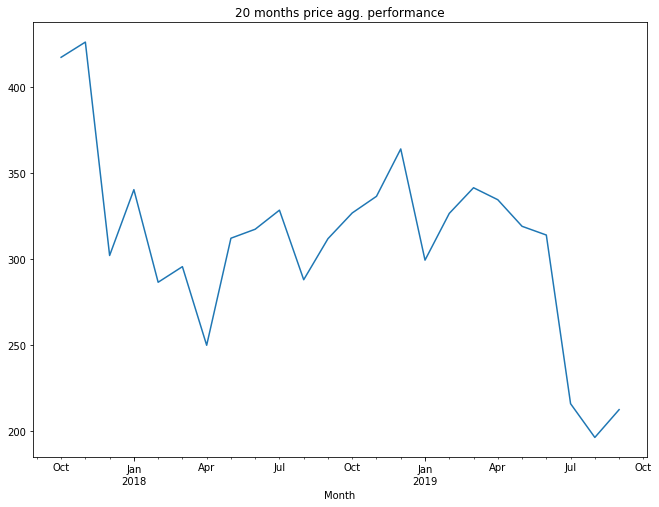

In [31]:
df_periods = df_pp_ndb_index_all_season.groupby('Month')[' CUR MAT '].mean()
plot_info(df_periods,'20 months price agg. performance')

### Opportunity Items: min(FY2018); max(FY2018); min(FY2019) if max-min_1 > max-min_2

In [32]:
# Cut time data set
period_1 = df_pp_ndb_index[df_pp_ndb_index.Month<'2018-10-01'].sort_values(by = 'Month')
period_2 = df_pp_ndb_index[df_pp_ndb_index.Month>='2018-10-01'].sort_values(by = 'Month')

In [33]:
p_1_grouped = period_1.groupby(['SUPPLIER NAME','SUPPLIER #','ITEM #'])[[' CUR MAT ','CRU HRC']].agg(['first','last'])
p_1_grouped.columns = p_1_grouped.columns.map('_fy18_'.join).str.strip('|')

p_2_grouped = period_2.groupby(['SUPPLIER NAME','SUPPLIER #','ITEM #'])[[' CUR MAT ','CRU HRC']].agg(['first','last'])
p_2_grouped.columns = p_2_grouped.columns.map('_fy19_'.join).str.strip('|')

# merge p_1 grouped and p_2 grouped
p_1_2_grouped = p_1_grouped.merge(p_2_grouped,on=['SUPPLIER NAME','SUPPLIER #','ITEM #'],how='outer')

# cleaning before exporting
p_1_2_grouped = col_name(p_1_2_grouped)
p_1_2_grouped.dropna(axis=0,how='any', inplace=True)

In [34]:
def percent_of_numbers(num1,num2):  
    return round((num2/num1)-1,2)

# period 1 inputs
p1_fp = p_1_2_grouped.cur_mat__fy18_first
p1_lp = p_1_2_grouped.cur_mat__fy18_last
p1_fi = p_1_2_grouped.cru_hrc_fy18_first
p1_li = p_1_2_grouped.cru_hrc_fy18_last

# period 2 inputs
p2_fp = p_1_2_grouped.cur_mat__fy19_first
p2_lp = p_1_2_grouped.cur_mat__fy19_last
p2_fi = p_1_2_grouped.cru_hrc_fy19_first
p2_li = p_1_2_grouped.cru_hrc_fy19_last

# period-1 percent
p_1_2_grouped['fy18_price_delta'] = percent_of_numbers(p1_fp,p1_lp)
p_1_2_grouped['fy18_index_delta'] = percent_of_numbers(p1_fi,p1_li)

# period-1 last and period-2 first percent
p_1_2_grouped['gap_price_delta'] = percent_of_numbers(p1_lp,p2_fp)
p_1_2_grouped['gap_index_delta'] = percent_of_numbers(p1_li,p2_fi)

# period-2 percent
p_1_2_grouped['fy19_price_delta'] = percent_of_numbers(p2_fp,p2_lp)
p_1_2_grouped['fy19_index_delta'] = percent_of_numbers(p2_fi,p2_li)

In [36]:
new_col = ['cur_mat__fy18_first', 'cur_mat__fy18_last', 'cru_hrc_fy18_first',
       'cru_hrc_fy18_last', 'cur_mat__fy19_first', 'cur_mat__fy19_last',
       'cru_hrc_fy19_first', 'cru_hrc_fy19_last', 'fy18_price_delta',
       'gap_price_delta','fy19_price_delta', 'fy18_index_delta', 'gap_index_delta',
       'fy19_index_delta']
p_1_2_grouped = p_1_2_grouped.reindex(columns=new_col)

# aggregate fluctuation price and indexes
p_1_2_grouped['price_impact'] = p_1_2_grouped.fy18_price_delta + p_1_2_grouped.gap_price_delta + p_1_2_grouped.fy19_price_delta
p_1_2_grouped['index_impact'] = p_1_2_grouped.fy18_index_delta + p_1_2_grouped.gap_index_delta + p_1_2_grouped.fy19_index_delta

# indexex impact rate to price
impact_rate = 0.6
p_1_2_grouped['overall_impact'] = p_1_2_grouped.price_impact - p_1_2_grouped.index_impact * impact_rate

In [37]:
p_1_2_grouped.to_csv(r'result_low-high-low_analysis.csv')

## Condition 1: find items having both Oct 2017 and Sep 2019 price

In [39]:
# find items having both Oct 2017 and Sep 2019 price
df_pp_ndb_index_2017or2019  = df_pp_ndb_index[np.logical_or(df_pp_ndb_index['IFM DATE'] == '201710',
               df_pp_ndb_index['IFM DATE'] == '201909')]

In [40]:
df_pp_ndb_index_2017or2019  = df_pp_ndb_index[np.logical_or(df_pp_ndb_index['Period'] == 'FY18Q1',
               df_pp_ndb_index['Period'] == 'FY19Q4')]

In [41]:
x = df_pp_ndb_index_2017or2019.groupby(['ITEM #','Period'])['Period'].count()

## Condition 2: period 2 corr < period 1 corr

In [42]:
# Cut time data set
period_1 = df_pp_ndb_index[df_pp_ndb_index.Month<'2018-10-01']
period_2 = df_pp_ndb_index[df_pp_ndb_index.Month>='2018-10-01']

# corr calculation
period_1_corr = period_1.groupby(['SUPPLIER #', 'SUPPLIER NAME', 'ITEM #'])[[' CUR MAT ','CRU HRC']].corr().iloc[0::2,-1].reset_index()
period_2_corr = period_2.groupby(['SUPPLIER #', 'SUPPLIER NAME', 'ITEM #'])[[' CUR MAT ','CRU HRC']].corr().iloc[0::2,-1].reset_index()

# drop NA corr
period_1_corr.dropna(subset=['CRU HRC'],inplace=True)
period_2_corr.dropna(subset=['CRU HRC'],inplace=True)

# rename corr per period
period_1_corr = period_1_corr.rename(columns={'CRU HRC':'P_1_corr'})
period_2_corr = period_2_corr.rename(columns={'CRU HRC':'P_2_corr'})

In [ ]:
# period_2_corr[period_2_corr['ITEM #']=='1001215373']
# df_pp_ndb_index[df_pp_ndb_index['ITEM #'] == '1001215373'].sort_values(by='Month')
# period_2[period_2['ITEM #'] == '1001215373'].groupby(['SUPPLIER #', 'SUPPLIER NAME', 'ITEM #'])[[' CUR MAT ','CRU HRC']].corr().iloc[0::2,-1].reset_index()
# period_1_corr[np.logical_and(period_1_corr['SUPPLIER #']==161800,period_1_corr['ITEM #'] == '1001172834C')]

In [43]:
# P_1 and P_2 corr merging
P_1_2_corr = period_1_corr.merge(period_2_corr[['SUPPLIER #', 'SUPPLIER NAME','ITEM #','P_2_corr']],on=['SUPPLIER #', 'SUPPLIER NAME','ITEM #'], how='outer')

# P_2_corr < P_1_corr
# P_1_2_corr = P_1_2_corr[P_1_2_corr.P_2_corr<P_1_2_corr.P_1_corr]
P_1_2_corr.to_csv(r'result_p2_corr_lower_.csv',index=False,header=True)

### Combining corr analysis and 1221 analysis

In [44]:
# merge corr analysis and first-last-last-first analysis
p_corr_1221 = p_1_2_grouped.reset_index().merge(P_1_2_corr[['SUPPLIER #', 'SUPPLIER NAME', 'ITEM #', 'P_1_corr','P_2_corr']], 
                                                on=['SUPPLIER #', 'SUPPLIER NAME', 'ITEM #'], 
                                                how = 'left')
p_corr_1221.to_csv(r'result_corr_1221_.csv',index=False,header=True)

In [45]:
# index selection for 2 fiscal years
df_ndb_index_f_3FY = df_ndb_index_f[np.logical_and( df_ndb_index_f['Month']>'2016-09-01', df_ndb_index_f['Month']<'2019-10-01')]

# df_ndb_index_f_10=df_ndb_index_f[np.logical_and(df_ndb_index_f['Month']>'2018-9-01',df_ndb_index_f['Month']<'2019-08-01')]
baseline = df_ndb_index_f_3FY[np.logical_and(df_ndb_index_f_3FY['Month']>'2016-9-01',df_ndb_index_f_3FY['Month']<'2019-10-01')]

# indexes lag_table
baselines = pd.DataFrame([baseline['CRU HRC'].shift(i)[-12:] for i in range (1,13)]).transpose()
baselines.columns = ['Lag1','Lag2','Lag3','Lag4','Lag5','Lag6','Lag7','Lag8','Lag9','lag10',
                    'Lag11','Lag12']

baselines = pd.concat([baseline.iloc[-12:,:],baselines],axis=1).reset_index()

In [46]:
# ppv + index + indexex_lag
df_pp_ndb_index_lags = pd.merge(df_pp_ndb_index[['IFM DATE', 'SUPPLIER #', 'SUPPLIER NAME', 'ITEM #',
       'ITEM DESCRIPTION', ' STD MAT ', ' CUR MAT ']],baselines[['Period', 'Year', ' Quarter', 'Cal Mo ID', 'Month', 'CRU HRC', 'YYYYMM',
       'Lag1', 'Lag2', 'Lag3', 'Lag4', 'Lag5', 'Lag6', 'Lag7', 'Lag8', 'Lag9',
       'lag10', 'Lag11', 'Lag12']], how='left', left_on='IFM DATE', right_on='YYYYMM')

df_pp_ndb_index_lags = df_pp_ndb_index_lags[np.logical_and( df_pp_ndb_index_lags['Month']>'2018-09-01', df_pp_ndb_index_lags['Month']<'2019-10-01')]

In [47]:
# material price corr with each lag
df_pp_ndb_index_lags_corr = df_pp_ndb_index_lags.groupby(['SUPPLIER #', 'SUPPLIER NAME', 'ITEM #'])[[' CUR MAT ','CRU HRC']].corr().iloc[0::2,-1].reset_index()
df_pp_ndb_index_lags_corr.drop(df_pp_ndb_index_lags_corr.columns[3],axis = 1, inplace=True)
for i in range(12):
    df_new_lag = df_pp_ndb_index_lags.groupby(['SUPPLIER #', 'SUPPLIER NAME', 'ITEM #'])[[' CUR MAT ',df_pp_ndb_index_lags.columns[14+i]]].corr().iloc[0::2,-1].reset_index()
    df_new_lag.drop(df_new_lag.columns[3],axis=1,inplace=True)
    df_pp_ndb_index_lags_corr= pd.merge(df_pp_ndb_index_lags_corr,df_new_lag,on=['SUPPLIER #', 'SUPPLIER NAME', 'ITEM #'],how='outer')

In [48]:
df_pp_ndb_index_lags_corr.to_csv(r'index_lags_corr.csv')

In [49]:
df_pp_ndb_index_lags_corr['max_corr_lag'] =df_pp_ndb_index_lags_corr.iloc[:,3:].idxmax(axis = 1, skipna = True) 
df_pp_ndb_index_lags_corr['max_corr'] = df_pp_ndb_index_lags_corr.iloc[:,3:].max(axis = 1, skipna = True) 

In [50]:
df_pp_ndb_index_lags_corr.to_csv(r'index_lags_corr.csv')

In [51]:
# merge 1221 & periods_corr & corr_lags
p_corr_1221_lags = p_corr_1221.merge(df_pp_ndb_index_lags_corr[['SUPPLIER #', 'SUPPLIER NAME', 'ITEM #','max_corr_lag', 'max_corr']],on=['SUPPLIER NAME', 'SUPPLIER #', 'ITEM #'], how='left')
p_corr_1221_lags_max = p_corr_1221_lags.dropna(subset=['max_corr_lag'], axis=0)

In [52]:
# max_lag index for corresponding index, e.g, 832 current with lag4  = 899
_row_19first = p_corr_1221_lags_max['cru_hrc_fy19_first'].apply(lambda x: (baselines['CRU HRC'] == x).idxmax())
_row_19last = p_corr_1221_lags_max['cru_hrc_fy19_last'].apply(lambda x: (baselines['CRU HRC'] == x).idxmax())
_col = p_corr_1221_lags_max['max_corr_lag'].apply(lambda x: baselines.columns.get_loc(x))
max_index = np.array(pd.concat([_row_19first,_row_19last,_col],axis=1).reset_index())
p_corr_1221_lags_max['max_cru_hrc_fy19_first'] = [baselines.iloc[max_index[i][1],max_index[i][3]] for i in range(len(max_index))]
p_corr_1221_lags_max['max_cru_hrc_fy19_last'] = [baselines.iloc[max_index[i][2],max_index[i][3]] for i in range(len(max_index))]

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


In [53]:
# find max_corr >=0.5
p_corr_1221_lags_max_05 = p_corr_1221_lags_max.where(p_corr_1221_lags_max['max_corr']> 0.5).dropna(subset=['max_corr'])

In [54]:
# find best opportunity of price difference: est.price - last ocurrance price in 2019
p_corr_1221_lags_max_05['predicted_price_2019'] = (p_corr_1221_lags_max_05.max_cru_hrc_fy19_last/p_corr_1221_lags_max_05.max_cru_hrc_fy19_first)*p_corr_1221_lags_max_05.cur_mat__fy19_first
p_corr_1221_lags_max_05['price_diff_opportunity'] = p_corr_1221_lags_max_05['predicted_price_2019'] - p_corr_1221_lags_max_05.cur_mat__fy19_last

In [55]:
p_corr_1221_lags_max_05.to_csv(r'result_max_opportunity.csv',index=False)

In [ ]:
def item_history_plot(vendor_id,item_id): 
    df = df_pp_ndb_index[np.logical_and(df_pp_ndb_index['SUPPLIER #']==vendor_id,df_pp_ndb_index['ITEM #'] == item_id)][['Month',' CUR MAT ','CRU HRC']].set_index('Month')
    plt.figure()
    df.iloc[:,0].plot()
    df.iloc[:,1].plot(secondary_y=True, style='g')
    plt.show
    return df

In [ ]:
input = [161928,'1001163469']

vendor_id = input[0]
item_id = str(input[1])

In [ ]:
item_history_plot(vendor_id,item_id)

## Condition 3: 12-months price performance for each period

In [61]:
dl = ['ITEM #','IFM DATE']
df1 = df_ndb_index_f[np.logical_and((df_ndb_index_f.Month>'2017-09-01'),(df_ndb_index_f.Month<'2019-10-01'))].iloc[:,[4,-2]].set_index('Month')
df2 = all_season_item(df_pp_ndb_index,dup_list=dl,s=23).iloc[:,[7,-3]].set_index('Month').groupby('Month')[' CUR MAT '].mean()
df3 = all_season_item(period_1,dup_list=dl,s=12).iloc[:,[7,-3]].set_index('Month').groupby('Month')[' CUR MAT '].mean()
df4 = all_season_item(period_2,dup_list=dl,s=12).iloc[:,[7,-3]].set_index('Month').groupby('Month')[' CUR MAT '].mean()

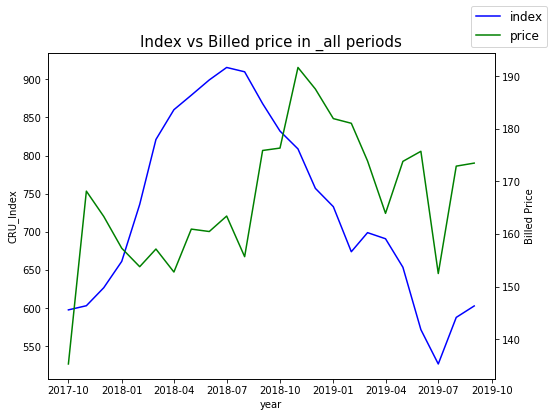

In [62]:
plot_index_info(df1,df2, title='_all periods')

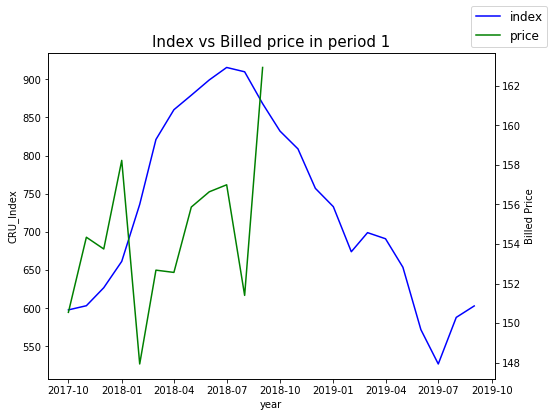

In [60]:
plot_index_info(df1,df3, title='period 1')

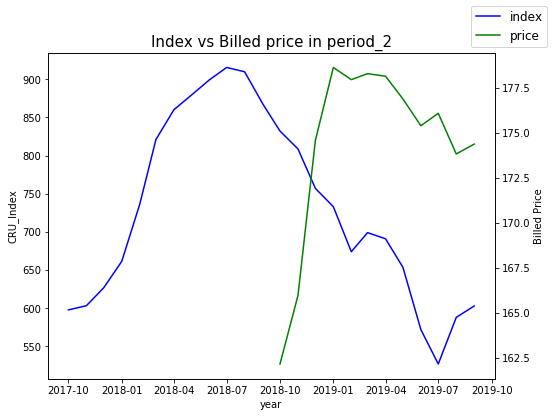

In [59]:
plot_index_info(df1,df4, title='period_2')

### Hypothsis: No lag between index and average material price

In [ ]:
# 2019 index
df1_2019 = df1.iloc[df1.index>'2017-10-01'].iloc[:,0]

# 2019 parts with average price
df2_2019 = df2[13:24]

# Corr of 2019 index and 
_corr = df1_2019.corr(df2_2019)
print(f'2019 index and material price corr is {round(_corr,4)}')

### Individual Supplier Analysis

In [ ]:
# inirialize miller dataset
df_ndb_all = col_name(df_pp_ndb_index)

In [ ]:
d = {'month': ['month_x', 'month_y']}
df_all = df_ndb_all.rename(columns=lambda c: d[c].pop(0) if c in d.keys() else c)

In [ ]:
supplier_ls = df_all.groupby(['supplier_#','supplier_name'])['item_#'].count().sort_values(ascending = False)

In [ ]:
supplier_ls.head(7)

In [ ]:
supplier_name = 'miller'
df_supplier = df_ndb_all[df_ndb_all.supplier_name.apply(lambda x: supplier_name.lower() in str(x).lower())]
d = {'month': ['month_x', 'month_y']}
df_supplier = df_supplier.rename(columns=lambda c: d[c].pop(0) if c in d.keys() else c)

df_supplier_all = df_supplier.copy()
df_supplier_fy19 = df_supplier[df_supplier.month_y>'2018-09-01']
df_supplier_fy18 = df_supplier[np.logical_and((df_supplier.month_y>'2017-09-01'),(df_supplier.month_y<'2018-10-01'))]

# plot supplier price performance
dl = ['item_#','ifm_date']
df_index_19 = df_ndb_index_f[np.logical_and((df_ndb_index_f.Month>'2018-09-01'),(df_ndb_index_f.Month<'2019-10-01'))].iloc[:,[4,-2]].set_index('Month')
df_index_18 = df_ndb_index_f[np.logical_and((df_ndb_index_f.Month>'2017-09-01'),(df_ndb_index_f.Month<'2018-10-01'))].iloc[:,[4,-2]].set_index('Month')

df_supplier_all_items = all_season_item(df_supplier_all,dup_list=dl,s=12).iloc[:,[7,-3]].set_index('month_y').groupby('month_y')['cur_mat'].mean()
df_supplier_fy19_all_items = all_season_item(df_supplier_fy19,dup_list=dl,s=12).iloc[:,[7,-3]].set_index('month_y').groupby('month_y')['cur_mat'].mean()
df_supplier_fy18_all_items = all_season_item(df_supplier_fy18,dup_list=dl,s=12).iloc[:,[7,-3]].set_index('month_y').groupby('month_y')['cur_mat'].mean()

plot_index_info(df_index_19,df_supplier_fy19_all_items, title=f'{supplier_name}')

### Regression on index and material avg price

In [ ]:
model = LinearRegression()
model.fit(pp,ip)

In [ ]:
model.get_params()

In [ ]:
test = np.array([0.01])[:,np.newaxis]

In [ ]:
model.predict(test)

In [ ]:
model.score(pp,ip)

In [ ]:
plt.scatter(pp,ip)

In [ ]:
x_test = np.array([0.02])[:,np.newaxis]

In [ ]:
def f(x):
    """ function to approximate by polynomial interpolation"""
    return x * np.sin(x)

x= np.linspace(0, 10, 100)
x_plot = np.linspace(0, 10, 100)

rng = np.random.RandomState(24)
rng.shuffle(x)

x = np.sort(x[:20])
y = f(x)

X = x[:,np.newaxis]
X_plot = x_plot[:,np.newaxis]

model = make_pipeline(PolynomialFeatures(5),Ridge())

model.fit(X,y)

y_plot = model.predict(X_plot)

In [ ]:
def f(x):
    """ function to approximate by polynomial interpolation"""
    return x * np.sin(x)

In [ ]:
x= np.linspace(0, 10, 100)
x_plot = np.linspace(0, 10, 100)

In [ ]:
rng = np.random.RandomState(24)
rng.shuffle(x)

In [ ]:
x = np.sort(x[:20])
y = f(x)

X = x[:,np.newaxis]
X_plot = x_plot[:,np.newaxis]

model = make_pipeline(PolynomialFeatures(5),Ridge())

model.fit(X,y)

y_plot = model.predict(X_plot)

In [ ]:
X = x[:,np.newaxis]
X_plot = x_plot[:,np.newaxis]

In [ ]:
model = make_pipeline(PolynomialFeatures(5),Ridge())

In [ ]:
model.fit(X,y)

y_plot = model.predict(X_plot)

### - index lag prep.

In [ ]:
# # index selection for 2 fiscal years
# df_ndb_index_f_3FY = df_ndb_index_f[np.logical_and( df_ndb_index_f['Month']>'2016-09-01', df_ndb_index_f['Month']<'2019-08-01')]

# # df_ndb_index_f_10=df_ndb_index_f[np.logical_and(df_ndb_index_f['Month']>'2018-9-01',df_ndb_index_f['Month']<'2019-08-01')]
# baseline = df_ndb_index_f_3FY[np.logical_and(df_ndb_index_f_3FY['Month']>'2016-9-01',df_ndb_index_f_3FY['Month']<'2019-08-01')]

# # indexes lag_table
# baselines = pd.DataFrame([baseline['CRU HRC'].shift(i)[-10:] for i in range (1,18)]).transpose()
# baselines.columns = ['Lag1','Lag2','Lag3','Lag4','Lag5','Lag6','Lag7','Lag8','Lag9','lag10',
#                     'Lag11','Lag12','Lag13','Lag14','Lag15','Lag16','Lag17']

### - merge material with index for corr

In [ ]:
# concate lag_table with non-direct_buy index_10
df_ndb_index_f_lags = pd.concat([df_ndb_index_f_3FY[-10:],baselines],axis=1)

In [ ]:
# convert fiscal year --> calender year
df_pp_ndb['CYM'] = df_pp_ndb.loc[:,'FYM'].apply(lambda x: int(x)-3 if int(x)>4 else int(x) + 9)

In [ ]:
# sum aggregation of material (appear in all 10 month) price
df_current_price = df_pp_ndb.groupby('CYM')[' CUR MAT '].mean().reset_index()

In [ ]:
# merge material with index_lags for corr analysis
df_idx_corr = df_ndb_index_f_lags.merge(df_current_price[['CYM',' CUR MAT ']], left_on='Cal Mo ID', right_on='CYM', how='inner')

In [ ]:
df = df_idx_corr[['CRU HRC', 'Lag1','Lag2', 'Lag3', 'Lag4', 'Lag5', 'Lag6', 
                  'Lag7', 'Lag8', 'Lag9','lag10','Lag11', 'Lag12', 'Lag13', 
                  'Lag14', 'Lag15', 'Lag16', 'Lag17',' CUR MAT ']]

f = plt.figure(figsize=(12, 8))
plt.matshow(df.corr(), fignum=f.number)
plt.xticks(range(df.shape[1]), df.columns, fontsize=8, rotation=45)
plt.yticks(range(df.shape[1]), df.columns, fontsize=8)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=15)
#plt.title('Correlation Matrix', fontsize=20)

In [ ]:
df_idx_corr[['CRU HRC', 'Lag1','Lag2', 'Lag3','Lag9','lag10','Lag11', 'Lag12',' CUR MAT ']].corr()

In [ ]:
df1 = df_ndb_index_f_3FY.iloc[:,-2:].set_index('Month')
df2 = df_idx_corr.iloc[:,[4,-1]].set_index('Month')
plot_index_info(df1,df2)

### Corr analysis explanation
#### - index price performance (see fig 1.1)
#### - 10_representitive material price performance
### conclusion: material pricing change not align with index performance

### Clawback analysis (non_direct buy parts)

### Part price history visulization

In [ ]:
def item_history_plot(vendor_id,item_id):
    file = [f for f in os.listdir() if'ppv_all' in f][0]
    df_pp = pd.read_csv(file)   
    df = df_pp[np.logical_and(df_pp['SUPPLIER #']==vendor_id,df_pp['ITEM #'] == item_id)][['CUR MAT','CRU HRC']]
    plt.figure()
    df.iloc[:,0].plot()
    df.iloc[:,1].plot(secondary_y=True, style='g')
    plt.show

In [ ]:
sid = 604504
iid = '1001164082'

In [ ]:
item_history_plot(sid,iid)